_Neural Data Analysis_

Lecturer: Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Rita González Márquez, Fabio Seel

Summer term 2024

Name: Stephan Amann, Hannah Blaurock, David Kleindiek

# Coding Lab 5



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
import scipy.io as io
import scipy.special as sp  # for array factorial and log function

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

%matplotlib inline
plt.style.use("../matplotlib_style.txt")

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2024-06-11 08:53:44CEST

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.24.0

sklearn: 1.4.2

scipy     : 1.13.0
matplotlib: 3.8.4
numpy     : 1.26.4

Watermark: 2.4.3



## Task 1: Fit RF on simulated data

We will start  with toy data generated from an LNP model neuron to make sure everything works right. The model LNP neuron consists of one Gaussian linear filter, an exponential nonlinearity and a Poisson spike count generator. We look at it in discrete time with time bins of width $\delta t$. The model is:

$$
c_t \sim Poisson(r_t)\\
r_t = \exp(w^T s_t) \cdot \Delta t \cdot R
$$

Here, $c_t$ is the spike count in time window $t$ of length $\Delta t$, $s_t$ is the stimulus and $w$ is the receptive field of the neuron. The receptive field variable `w` is 15 × 15 pixels and normalized to $||w||=1$. A stimulus frame is a 15 × 15 pixel image, for which we use uncorrelated checkerboard noise. R can be used to bring the firing rate into the right regime (e.g. by setting $R=50$).      

For computational ease, we reformat the stimulus and the receptive field in a 225 by 1 array. The function ```sample_lnp``` can be used to generate data from this model. It returns a spike count vector `c` with samples from the model (dimensions: 1 by nT = $T/\Delta t$), a stimulus matrix `s` (dimensions: 225 × nT) and the mean firing rate `r` (dimensions: nT × 1). 

Here we assume that the receptive field influences the spike count instantaneously just as in the above equations. Implement a Maximum Likelihood approach to fit the receptive field. 

To this end simplify and implement the log-likelihood function $L(w)$ and its gradient $\frac{L(w)}{dw}$ with respect to $w$ (`negloglike_lnp`). The log-likelihood of the model is
$$L(w) = \log \prod_t \frac{r_t^{c_t}}{c_t!}\exp(-r_t).$$

Plot the true receptive field, a stimulus frame, the spike counts and the estimated receptive field. 

*Grading: 2 pts (calculations) + 3 pts (implementation)*


### Calculations
_You can add your calculations in_ $\LaTeX$ _here_.

$$\begin{align*}
L(\omega)   &= \sum_t \left( \log(\frac{r_t^{c_t}}{c_t!}) + \log(\exp(-r_t)) \right) \\
            &= \sum_t \left( \log(r_t^{c_t}) - \log(c_t!) + \log(\exp(-r_t)) \right) \\
            &= \sum_t \left( c_t \log(r_t) - \log(c_t!) - r_t \right) \\
            &= \sum_t \left( c_t \log(\exp(w^T s_t) \cdot \Delta t \cdot R) - \log(c_t!) - \exp(w^T s_t) \cdot \Delta t \cdot R \right) & \text{// insert $r_t$} \\
            &= \sum_t \left( c_t (w^T s_t) + c_t \log(\Delta t) + c_t \log(R) - \log(c_t!) - \exp(w^T s_t) \cdot \Delta t \cdot R \right) \\
            &= \sum_t \left( c_t \left((w^T s_t) + \log(\Delta t) + \log(R) \right) - \log(c_t!) - \exp(w^T s_t) \cdot \Delta t \cdot R \right) \\
\\
\frac{dL(\omega)}{d\omega}  &= \sum_t \left( c_t \cdot s_t - s_t \cdot \exp(w^T s_t) \cdot \Delta t \cdot R \right) \\
                            &= \sum_t \left( s_t (c_t - \exp(w^T s_t) \cdot \Delta t \cdot R) \right) \\
                            &= \sum_t \left( s_t (c_t - r_t) \right)
\end{align*}$$

### Generate data

Text(0.5, 1.0, 'Gaussian RF')

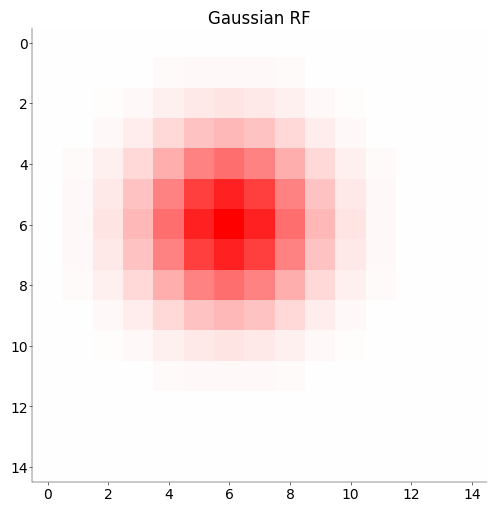

In [ ]:
def gen_gauss_rf(D: int, width: float, center: tuple = (0, 0)) -> np.ndarray:
    """
    Generate a Gaussian receptive field.

    Args:
        D (int): Size of the receptive field (DxD).
        width (float): Width parameter of the Gaussian.
        center (tuple, optional): Center coordinates of the receptive field. Defaults to (0, 0).

    Returns:
        np.ndarray: Gaussian receptive field.
    """

    sz = (D - 1) / 2
    x, y = np.meshgrid(np.arange(-sz, sz + 1), np.arange(-sz, sz + 1))
    x = x + center[0]
    y = y + center[1]
    w = np.exp(-(x**2 / width + y**2 / width))
    w = w / np.sum(w.flatten())

    return w


w = gen_gauss_rf(15, 7, (1, 1))

vlim = np.max(np.abs(w))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(w, cmap="bwr", vmin=-vlim, vmax=vlim)
ax.set_title("Gaussian RF")

In [ ]:
def sample_lnp(
    w: np.array, nT: int, dt: float, R: float, v: float, random_seed: int = 10
):
    """Generate samples from an instantaneous LNP model neuron with
    receptive field kernel w.

    Parameters
    ----------

    w: np.array, (Dx * Dy, )
        (flattened) receptive field kernel.

    nT: int
        number of time steps

    dt: float
        duration of a frame in s

    R: float
        rate parameter

    v: float
        variance of the flattened stimulus array

    random_seed: int
        seed for random number generator

    Returns
    -------

    c: np.array, (nT, )
        sampled spike counts in time bins

    r: np.array, (nT, )
        mean rate in time bins

    s: np.array, (Dx * Dy, nT)
        stimulus frames used

    Note
    ----

    See equations in task description above for a precise definition
    of the individual parameters.

    """

    rng = np.random.default_rng(random_seed)

    # insert your code here

    # create stimulus frames from uncorrelated checkerboard noise
    # s = rng.normal(0, np.sqrt(v), (w.size, nT)) # our first attempt
    # checkerboard noise using the way described in the tutorial session
    # rng.choice draws basically from a discrete uniform distribution, as each value is equally likely
    s = rng.choice([-1, 1], (w.size, nT)) * np.sqrt(v)
    print("shape s (Dx * Dy, nT): ", s.shape)
    print("mean(s): ", np.mean(s))
    print("var(s): ", np.var(s))

    # compute the mean rate in time bins
    r = np.exp(np.dot(w, s)) * dt * R
    print("shape r (nT,): ", r.shape)

    # draw spike counts from a Poisson distribution
    c = rng.poisson(r)
    print("shape c (nT,): ", c.shape)

    # ------------------------------------------------
    # Generate samples from an instantaneous LNP model
    # neuron with receptive field kernel w. (0.5 pts)
    # ------------------------------------------------

    return c, r, s

In [ ]:
D = 15  # number of pixels
nT = 1000  # number of time bins
dt = 0.1  # bins of 100 ms
R = 50  # firing rate in Hz
v = 20  # stimulus variance

w = gen_gauss_rf(D, 7, (1, 1))
w = w.flatten()

print("||w||: ", np.sum(w))

c, r, s = sample_lnp(w, nT, dt, R, v)

||w||:  1.0
shape s (Dx * Dy, nT):  (225, 1000)
mean(s):  -0.015026376808798592
var(s):  19.999774208
shape r (nT,):  (1000,)
shape c (nT,):  (1000,)


Plot the stimulus for one frame, the cell's response over time and the spike count vs firing rate.

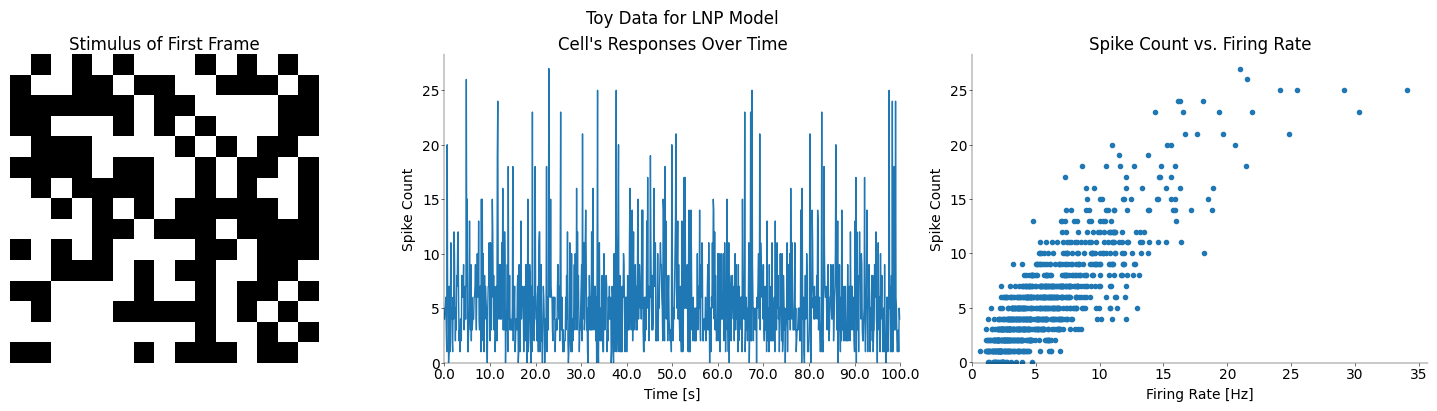

In [ ]:
mosaic = mosaic = [["stim", "responses", "count/rate"]]

fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(15, 4))
# -----------------------------------------------------------------------------------------------------------
# Plot the stimulus for one frame, the cell's responses over time and spike count vs firing rate (0.5 points)
# -----------------------------------------------------------------------------------------------------------

# plot the stimulus for one frame
ax["stim"].imshow(s[:, 0].reshape(D, D), cmap="gray")
ax["stim"].set_title("Stimulus of First Frame")
ax["stim"].axis("off")

# plot the cell's responses over time
ax["responses"].plot(c)
ax["responses"].set_title("Cell's Responses Over Time")
ax["responses"].set_xlabel("Time [s]")
ax["responses"].set_ylabel("Spike Count")
ax["responses"].set_xlim([0, nT + 1])
ax["responses"].set_ylim(bottom=0)
ax["responses"].set_xticks(range(0, nT + 1, 100))
ax["responses"].set_xticklabels(np.arange(0.0, nT + 1, 100) * dt)

# plot spike count vs firing rate
ax["count/rate"].plot(r, c, ".")
ax["count/rate"].set_xlabel("Firing Rate [Hz]")  # TODO is this correct?
ax["count/rate"].set_ylabel("Spike Count")
ax["count/rate"].set_xlim(left=0)
ax["count/rate"].set_ylim(bottom=-0.05)
ax["count/rate"].set_title("Spike Count vs. Firing Rate")

plt.suptitle("Toy Data for LNP Model")

plt.show()

### Implementation 

Implement the negative log-likelihood of the LNP and its gradient with respect to the receptive field using the simplified equations you calculated earlier _(0.5 pts)_

$$\begin{align*}
-L(\omega)   &= -\sum_t \left( c_t \log(r_t) - \log(c_t!) - r_t \right) \\
\\
-\frac{dL(\omega)}{d\omega}  &= -\sum_t \left( s_t (r_t - c_t) \right)
\end{align*}$$

In [ ]:
def negloglike_lnp(
    w: np.array, c: np.array, s: np.array, dt: float = 0.1, R: float = 50
) -> float:
    """Implements the negative (!) log-likelihood of the LNP model

    Parameters
    ----------

    w: np.array, (Dx * Dy, )
      current receptive field

    c: np.array, (nT, )
      spike counts

    s: np.array, (Dx * Dy, nT)
      stimulus matrix


    Returns
    -------

    f: float
      function value of the negative log likelihood at w

    """

    # ------------------------------------------------
    # Implement the negative log-likelihood of the LNP
    # ------------------------------------------------

    # compute dot product of w and s
    ws = np.dot(w, s)
    # compute the mean rate in time bins
    r = np.exp(ws) * dt * R

    # compute the negative log likelihood
    f = -np.sum(c * np.log(r) - np.log(sp.factorial(c)) - r)

    return f


def deriv_negloglike_lnp(
    w: np.array, c: np.array, s: np.array, dt: float = 0.1, R: float = 50
) -> np.array:
    """Implements the gradient of the negative log-likelihood of the LNP model

    Parameters
    ----------

    see negloglike_lnp

    Returns
    -------

    df: np.array, (Dx * Dy, )
      gradient of the negative log likelihood with respect to w

    """

    # --------------------------------------------------------------
    # Implement the gradient with respect to the receptive field `w`
    # --------------------------------------------------------------

    # compute dot product of w and s
    ws = np.dot(w, s)
    # compute the mean rate in time bins
    r = np.exp(ws) * dt * R
    # compute the gradient
    df = np.dot(s, (r - c))  # switched r and c to match negative log likelihood

    return df

The helper function `check_grad` in `scipy.optimize` can help you to make sure your equations and implementations are correct. It might be helpful to validate the gradient before you run your optimizer.

In [ ]:
# Check gradient
# insert your code here

# compute negative log likelihood and gradient
f = negloglike_lnp(w, c, s)
df = deriv_negloglike_lnp(w, c, s)

print(f"Negative log likelihood: {f}")
# print(f"Gradient: {df}")

# check gradient
err = opt.check_grad(negloglike_lnp, deriv_negloglike_lnp, w, c, s)
print(f"Error of gradient: {err}")

Negative log likelihood: 2184.700784928
Error of gradient: 0.013504701220919482


Fit receptive field maximizing the log likelihood.

The scipy.optimize package also has suitable functions for optimization. If you generate a large number of samples, the fitted receptive field will look more similar to the true receptive field. With more samples, the optimization takes longer, however.

In [ ]:
# insert your code here

# ------------------------------------------
# Estimate the receptive field by maximizing
# the log-likelihood (or more commonly,
# minimizing the negative log-likelihood).
#
# Tips: use scipy.optimize.minimize(). (1 pt)
# ------------------------------------------

# we initialize with zeros
w_init = np.zeros_like(w)

result = opt.minimize(
    negloglike_lnp,
    w_init,
    args=(c, s),
    jac=deriv_negloglike_lnp,
    method="L-BFGS-B",  # Quasi-Newton Optimizer (memory efficient)
    options={"disp": True},  # print convergence messages
)

print("success: ", result.success)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          225     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32387D+03    |proj g|=  4.75835D+03

At iterate    1    f=  2.30408D+03    |proj g|=  1.44719D+03

At iterate    2    f=  2.13905D+03    |proj g|=  7.78368D+02

At iterate    3    f=  2.08826D+03    |proj g|=  3.97187D+02

At iterate    4    f=  2.07610D+03    |proj g|=  2.27985D+02

At iterate    5    f=  2.07242D+03    |proj g|=  1.15765D+02

At iterate    6    f=  2.07094D+03    |proj g|=  5.49240D+01

At iterate    7    f=  2.07058D+03    |proj g|=  4.26528D+01

At iterate    8    f=  2.07043D+03    |proj g|=  1.68470D+01

At iterate    9    f=  2.07040D+03    |proj g|=  1.08915D+01

At iterate   10    f=  2.07039D+03    |proj g|=  5.41772D+00

At iterate   11    f=  2.07039D+03    |proj g|=  6.59900D+00

At iterate   12    f=  2.07038D+03    |proj g|=  1.39001D+00

At iterate   13    f=  2.0

 This problem is unconstrained.


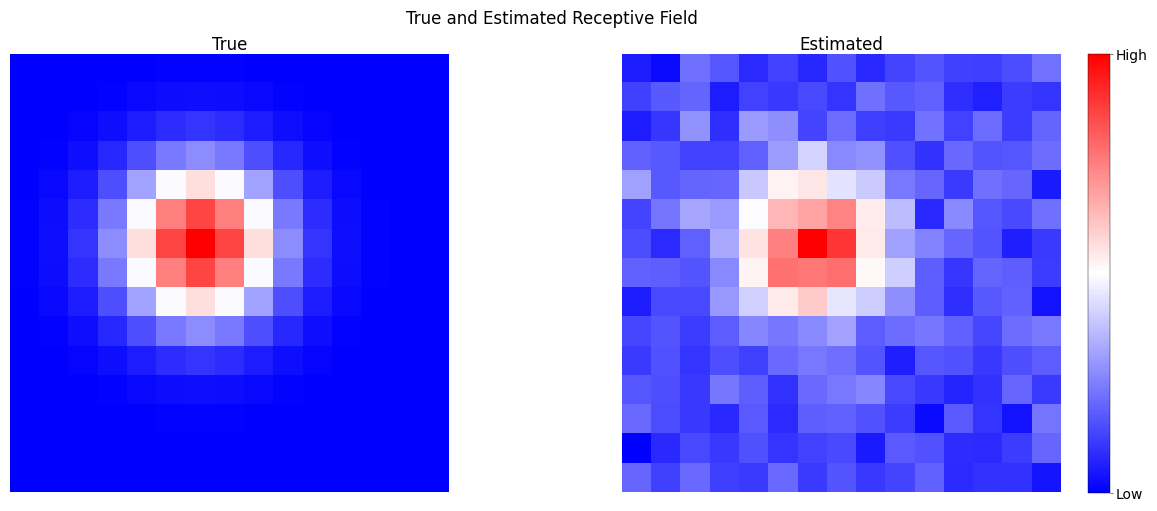

In [ ]:
# insert your code here

# ------------------------------------
# Plot the ground truth and estimated
# `w` side by side. (0.5 pts)
# ------------------------------------

mosaic = [["True", "Estimated"]]
fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(12, 5))

ax["True"].imshow(w.reshape(D, D), cmap="bwr")
ax["True"].set_title("True")
# cbar = fig.colorbar(im, ax=ax["True"], orientation="vertical")

im = ax["Estimated"].imshow(result.x.reshape(D, D), cmap="bwr")
ax["Estimated"].set_title("Estimated")

# color bar
cbar = fig.colorbar(im, ax=ax["Estimated"], orientation="vertical")
cbar.set_ticks(ticks=[np.min(result.x), np.max(result.x)], labels=["Low", "High"])

for a in ax.values():
    a.axis("off")

plt.suptitle("True and Estimated Receptive Field")
plt.show()

## Task 2: Apply to real neuron

Download the dataset for this task from Ilias (`nds_cl_5_data.mat`). It contains a stimulus matrix (`s`) in the same format you used before and the spike times. In addition, there is an array called `trigger` which contains the times at which the stimulus frames were swapped.

* Generate an array of spike counts at the same temporal resolution as the stimulus frames
* Fit the receptive field with time lags of 0 to 4 frames. Fit them one lag at a time (the ML fit is very sensitive to the number of parameters estimated and will not produce good results if you fit the full space-time receptive field for more than two time lags at once). 
* Plot the resulting filters

*Grading: 2 pts*


In [ ]:
var = io.loadmat("../data/nds_cl_5_data.mat")

# t contains the spike times of the neuron
t = var["DN_spiketimes"].flatten()

# trigger contains the times at which the stimulus flipped
trigger = var["DN_triggertimes"].flatten()

# contains the stimulus movie with black and white pixels
s = var["DN_stim"]
print("original shape of stimulus: ", s.shape)
s = s.reshape((300, 1500))  # the shape of each frame is (20, 15)
s = s[:, 1 : len(trigger)]
print("mean(s): ", np.mean(s))
print("var(s): ", np.var(s))

original shape of stimulus:  (20, 15, 1500)
mean(s):  0.5007235663082438
var(s):  0.24999947645179754


In [ ]:
print("trigger.shape: ", trigger.shape)
print(trigger)

print("t.shape: ", t.shape)
print(t)

print("s.shape: ", s.shape)

trigger.shape:  (1489,)
[0.00000000e+00 2.13999939e-01 3.94400024e-01 ... 3.20177291e+02
 3.20423209e+02 3.20612896e+02]
t.shape:  (5500,)
[9.14999390e-02 1.00499878e-01 1.21199951e-01 ... 3.21578795e+02
 3.21603795e+02 3.21651998e+02]
s.shape:  (300, 1488)


Create vector of spike counts

In [ ]:
# insert your code here

# ------------------------------------------
# Bin the spike counts at the same temporal
# resolution as the stimulus (0.5 pts)
# ------------------------------------------

# we are interested in the amount of spikes between two triggers (stimulus swaps)
# one interval of trigger will be a bin in spike_count,
# therefore the number of bins equals len(trigger)
# the last bin will contain the remaining spikes after the last trigger is removed
spike_count = np.zeros(len(trigger))

# to make sure all time stamps are in ascending order
trigger.sort()
t.sort()

i_trigger = 0
i_spike = 0

while i_trigger < trigger.shape[0] - 1 and i_spike < t.shape[0]:
    spike = t[i_spike]
    # spike time is smaller than next trigger time -> increase count at trigger index and increment spike index
    if spike < trigger[i_trigger + 1]:
        spike_count[i_trigger] += 1
        i_spike += 1
    # spike time is equal or bigger than next trigger time -> increase trigger index and continue
    else:
        i_trigger += 1

# all remaining spikes belong to the last trigger index
spike_count[i_trigger] = t[i_spike:].shape[0]

# check if this is correct
print("number of spikes:\t", t.shape[0])
print("accumulated bins:\t", np.sum(spike_count))

number of spikes:	 5500
accumulated bins:	 5500.0


Fit receptive field for each frame separately

In [ ]:
# insert your code here

# ------------------------------------------
# Fit the receptive field with time lags of
# 0 to 4 frames separately (1 pt)
#
# The final receptive field (`w_hat`) should
# be in the shape of (Dx * Dy, 5)
# ------------------------------------------

# specify the time lags
delta = [0, 1, 2, 3, 4]
Dx = 20
Dy = 15
w_hat = np.zeros(((Dx * Dy), len(delta)))

# fit for each delay
for delay in delta:
    # data preparation
    w_init = np.zeros(s.shape[0])
    considered_spike_count = spike_count[:-1]
    considered_stimuli = s
    if delay > 0:
        considered_spike_count = spike_count[delay:]
        considered_stimuli = s[:, : (s.shape[1] - delay + 1)]

    result = opt.minimize(
        negloglike_lnp,
        w_init,
        args=(
            # spike_count[delay:spike_count_end],  # consider only spikes after the delay
            # s[
            #     :, : (s.shape[1] - delay)
            # ],  # cut the stimuli not fitting in the data anymore #TODO my old implementation
            considered_spike_count,
            considered_stimuli,
        ),
        jac=deriv_negloglike_lnp,
        method="L-BFGS-B",  # Quasi-Newton Optimizer (memory efficient)
        options={"disp": False},  # print convergence messages
    )
    w_hat[:, delay] = result.x

Plot the frames one by one

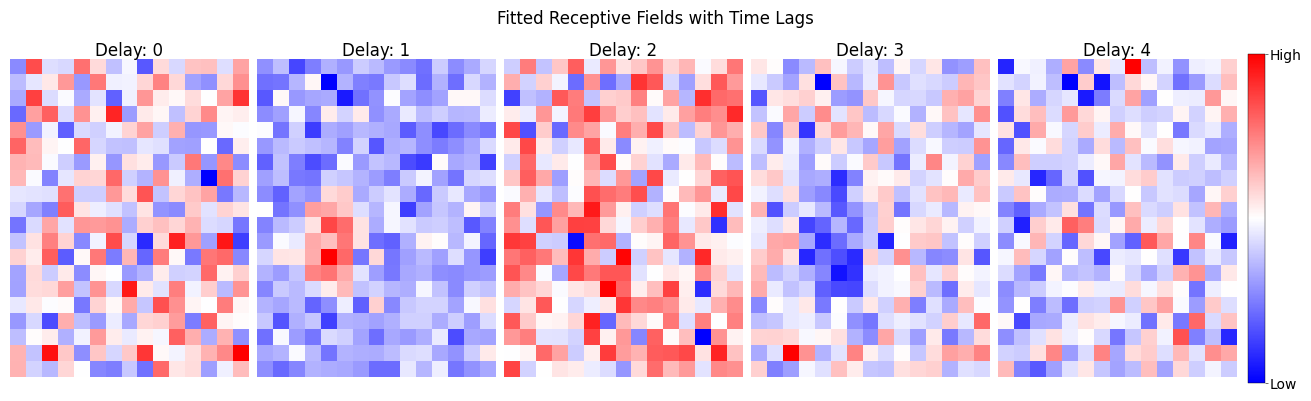

In [ ]:
# --------------------------------------------
# Plot all 5 frames of the fitted RFs (0.5 pt)
# --------------------------------------------

fig, ax = plt.subplot_mosaic(mosaic=[delta], figsize=(13, 4), constrained_layout=True)

for d in delta:
    im = ax[d].imshow(w_hat[:, d].reshape(Dx, Dy), cmap="bwr")
    ax[d].set_title(f"Delay: {d}")
    ax[d].axis("off")

# add colorbar
cbar = plt.colorbar(im, ax=ax[delta[-1]], orientation="vertical", shrink=0.9)
cbar.set_ticks(
    ticks=[np.min(w_hat[:, -1]), np.max(w_hat[:, -1])], labels=["Low", "High"]
)

plt.suptitle("Fitted Receptive Fields with Time Lags")
plt.show()

## Task 3: Separate space/time components

The receptive field of the neuron can be decomposed into a spatial and a temporal component. Because of the way we computed them, both are independent and the resulting spatio-temporal component is thus called separable. As discussed in the lecture, you can use singular-value decomposition to separate these two: 

$$
W = u_1 s_1 v_1^T
$$

Here $u_1$ and $v_1$ are the singular vectors belonging to the 1st singular value $s_1$ and provide a long rank approximation of W, the array with all receptive fields. It is important that the mean is subtracted before computing the SVD.  

Plot the first temporal component and the first spatial component. You can use a Python implementation of SVD. The results can look a bit puzzling, because the sign of the components is arbitrary.

*Grading: 1 pts*

w_hat_centered.shape:  (300, 5)


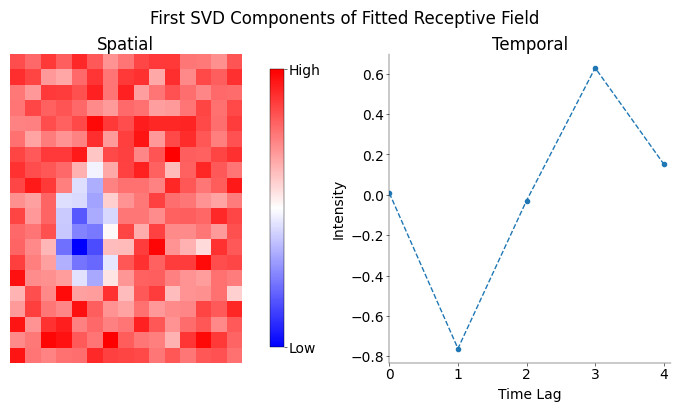

In [ ]:
# --------------------------------------------
# Apply SVD to the fitted receptive field,
# you can use either numpy or sklearn (0.5 pt)
# --------------------------------------------

# shape of w_hat: (300,5).
# subtract mean along axis=1 (time) since for every timelag the RF is estimated independently
w_hat_centered = (
    w_hat - np.mean(w_hat, axis=1)[:, np.newaxis]
)  # for each pixel over the 5 time steps the mean of them is subtracted, so the mean array is (300,1) and for subtraction it is broadcasted to (300,5)
print("w_hat_centered.shape: ", w_hat_centered.shape)

# svd
U, S, Vt = np.linalg.svd(w_hat_centered, full_matrices=False)
# U is the spatial component, Vt is the temporal component

# -------------------------------------------------
# Plot the spatial and temporal components (0.5 pt)
# -------------------------------------------------

fig, ax = plt.subplot_mosaic(
    mosaic=[["Spatial", "Temporal"]],
    width_ratios=[2, 1],
    figsize=(10, 4),
    constrained_layout=True,
)
# add plot
im = ax["Spatial"].imshow(U[:, 0].reshape(Dx, Dy), cmap="bwr")
ax["Spatial"].set_title("Spatial")
ax["Spatial"].axis("off")
cbar = plt.colorbar(im, ax=ax["Spatial"], orientation="vertical", shrink=0.9)
cbar.set_ticks(ticks=[np.min(U[:, 0]), np.max(U[:, 0])], labels=["Low", "High"])

ax["Temporal"].plot(Vt[0, :], ".--")
ax["Temporal"].set_title("Temporal")
ax["Temporal"].set_xlabel("Time Lag")
ax["Temporal"].set_ylabel("Intensity")
ax["Temporal"].set_xlim([0, 4.1])
ax["Temporal"].set_xticks(range(0, 5))
ax["Temporal"].set_xticklabels(range(0, 5))

plt.suptitle("First SVD Components of Fitted Receptive Field", position=(0.67, 1.05))
plt.show()

## Task 4: Regularized receptive field

As you can see, maximum likelihood estimation of linear receptive fields can be quite noisy, if little data is available. 

To improve on this, one can regularize the receptive field vector and a term to the cost function


$$
C(w) = L(w) + \alpha ||w||_p^2
$$

Here, the $p$ indicates which norm of $w$ is used: for $p=2$, this is shrinks all coefficient equally to zero; for $p=1$, it favors sparse solutions, a penality also known as lasso. Because the 1-norm is not smooth at zero, it is not as straightforward to implement "by hand". 

Use a toolbox with an implementation of the lasso-penalization and fit the receptive field. Possibly, you will have to try different values of the regularization parameter $\alpha$. Plot your estimates from above and the lasso-estimates. How do they differ? What happens when you increase or decrease $alpha$?

If you want to keep the Poisson noise model, you can use the implementation in [`pyglmnet`](https://pypi.python.org/pypi/pyglmnet). Otherwise, you can also resort to the linear model from `sklearn` which assumes Gaussian noise (which in my hands was much faster).

*Grading: 2 pts*


In [ ]:
from sklearn import linear_model

# insert your code here

# ------------------------------------------
# Fit the receptive field with time lags of
# 0 to 4 frames separately (the same as before)
# with sklern or pyglmnet (1 pt)
# ------------------------------------------

delta = [0, 1, 2, 3, 4]
Dx = 20
Dy = 15


def lasso_fit(s, spike_count, delta, alpha):
    """
    Fit the receptive field with time lags separately using Lasso regression.
    """
    w_hat = np.zeros(((Dx * Dy), len(delta)))

    # fit for each delay
    for delay in delta:
        # data preparation
        considered_spike_count = spike_count[:-1]
        considered_stimuli = s
        if delay > 0:
            considered_spike_count = spike_count[delay:]
            considered_stimuli = s[:, : (s.shape[1] - delay + 1)]

        # fit using sklearn.linear_model.Lasso
        clf = linear_model.Lasso(alpha=alpha)
        clf.fit(
            # s[:, : (s.shape[1] - delay)].T,
            # spike_count[delay:],
            considered_stimuli.T,
            considered_spike_count,
        )
        w_hat[:, delay] = clf.coef_

    return w_hat


# perform the fit for different alphas
alphas = [0.005, 0.01, 0.025, 0.03, 0.05, 0.07, 0.1]
w_hat_alpha = np.zeros(((Dx * Dy), len(delta), len(alphas)))
for a, alpha in enumerate(alphas):
    w_hat_alpha[:, :, a] = lasso_fit(s, spike_count, delta, alpha)

print(np.max(w_hat_alpha))
print(np.min(w_hat_alpha))

0.6047509430604794
-0.30561551694419065


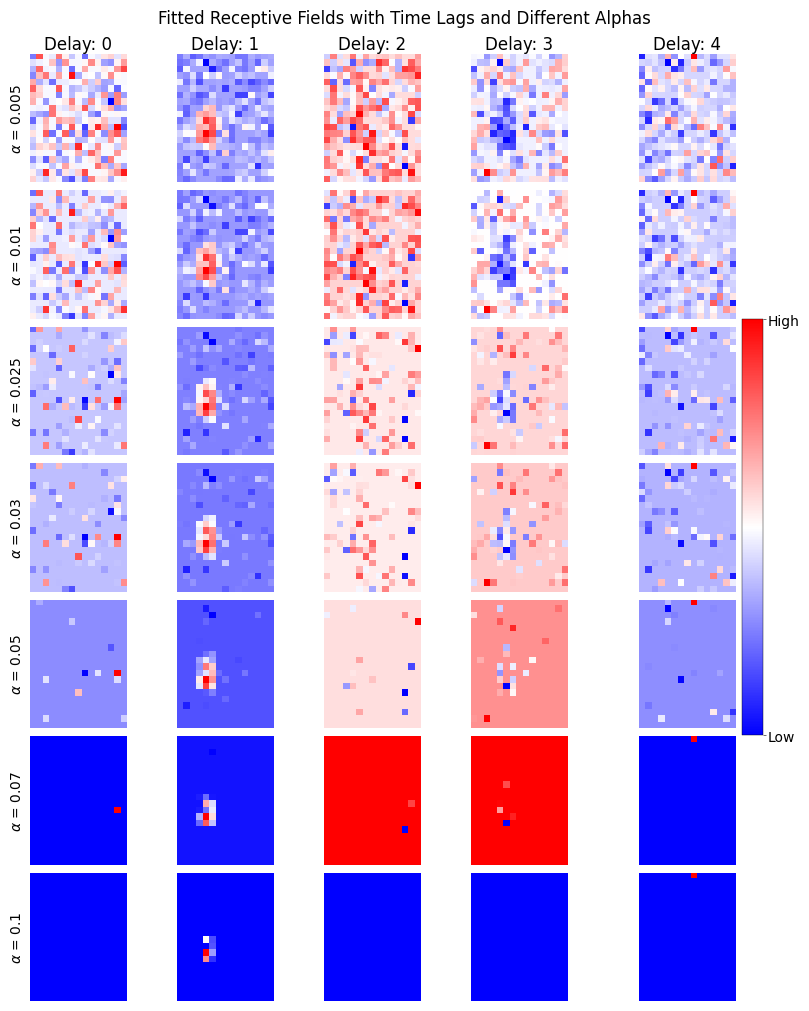

In [ ]:
fig, ax = plt.subplots(
    len(alphas), len(delta), figsize=(8, 10), constrained_layout=True
)

for a, alpha in enumerate(alphas):
    for d, delay in enumerate(delta):
        im = ax[a, d].imshow(w_hat_alpha[:, d, a].reshape(Dx, Dy), cmap="bwr")
        ax[a, d].set_xticks([])
        ax[a, d].set_yticks([])
        for spine in ax[a, d].spines.values():
            spine.set_visible(False)  # Hide the axis frame
        if a == 0:
            ax[a, d].set_title(f"Delay: {delay}")
    ax[a, 0].set_ylabel(f"$\\alpha$ = {alpha}")

# add color bar
cbar = plt.colorbar(im, ax=ax[:, -1], orientation="vertical")
cbar.set_ticks(
    ticks=[np.min(w_hat_alpha[:, -1, -1]), np.max(w_hat_alpha[:, -1, -1])],
    labels=["Low", "High"],
)

plt.suptitle("Fitted Receptive Fields with Time Lags and Different Alphas")
plt.show()

### Observations Changing $\alpha$

$\alpha$ penalizes harshly and reduces noise, which leads to no stimuli for RF with higher delays. At $\alpha$ = 0.1 the RF is no more interpretable.

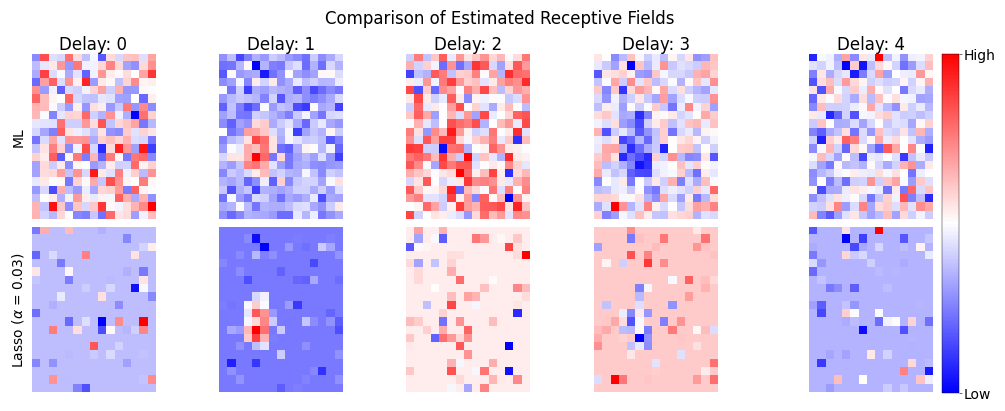

In [ ]:
# ------------------------------------------
# plot the estimated receptive fields (1 pt)
# ------------------------------------------

i_alpha = 3  # alpha = 0.03
w_hat_compare = np.zeros(((Dx * Dy), len(delta), 2))
w_hat_compare[:, :, 0] = w_hat
w_hat_compare[:, :, 1] = w_hat_alpha[:, :, i_alpha]
label = [f"ML", f"Lasso ($\\alpha$ = {alphas[i_alpha]})"]

fig, ax = plt.subplots(2, len(delta), figsize=(10, 4), constrained_layout=True)
# add plot
for d in delta:
    ax[0, d].imshow(w_hat_compare[:, d, 0].reshape(Dx, Dy), cmap="bwr")
    ax[0, d].set_title(f"Delay: {d}")
    im = ax[1, d].imshow(w_hat_compare[:, d, 1].reshape(Dx, Dy), cmap="bwr")

ax[0, 0].set_ylabel(label[0])
ax[1, 0].set_ylabel(label[1])

for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])
    for spine in a.spines.values():
        spine.set_visible(False)  # Hide the axis frame

# add color bar
cbar = plt.colorbar(im, ax=ax[:, -1], orientation="vertical")
cbar.set_ticks(
    ticks=[np.min(w_hat_compare[:, -1, 1]), np.max(w_hat_compare[:, -1, 1])],
    labels=["Low", "High"],
)

plt.suptitle("Comparison of Estimated Receptive Fields")
plt.show()

### Observations Comparison

In both fits the characteristic blob of a RF is clearly visible with delay 1 and 3. The latter is the swapped version. Overall Lasso with $\alpha = 0.03$ reduces noise better than ML.